In [24]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import math
import random
import functions
import hybrid_ann
import matplotlib.pyplot as plt
from RBF import RBF
from sklearn.neural_network import MLPRegressor
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm

In [2]:
df = pd.read_csv('beer.csv')
data = df.iloc[:, -1].values

serie_normal = functions.normalizar_serie(data)
serie_lags = functions.gerar_janelas(tam_janela = 5, serie = serie_normal)
X_train, y_train, X_test, y_test = functions.split_serie_with_lags(serie = serie_lags, perc_train = 0.8, perc_val = 0)

In [3]:
model = hybrid_ann.LNL_ANN(m = 5)

model.fit_MPSO(X = X_train, y = y_train, d= 30, c1i = 1.0, c1f = 2.0, c2i = 1.0, c2f = 2.0, w1 = 0.5, w2 = 1.0, maxt = 1000)
y_pred = model.predict(X_test)
# print('Prediction:', y_pred)
# print('Test:', y_test)

# Análise de Dados

## Conjunto de treinamento

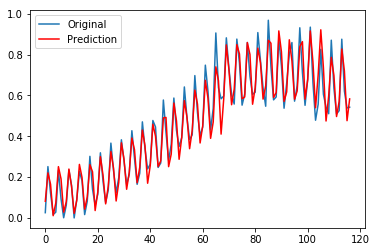

In [4]:
y_train_pred = model.predict(X_train)
plt.plot(y_train, label = 'Original')
plt.plot(y_train_pred, label = 'Prediction', color = 'red')
plt.legend()

## Test Data

In [141]:
y_test_ = functions.desnormalizar(y_test, data)
y_pred_ = functions.desnormalizar(y_pred, data)

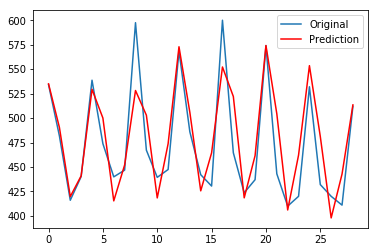

In [33]:
plt.plot(y_test_, label = 'Original')
plt.plot(y_pred_, label = 'Prediction', color = 'red')
plt.legend()

# Erro da série

In [6]:
resid_train = functions._error(y_train, y_train_pred)
resid_test = functions._error(y_test, y_pred)

In [7]:
resid_train_lags = functions.gerar_janelas(tam_janela = 2, serie = resid_train)
resid_test_lags = functions.gerar_janelas(tam_janela = 2, serie = resid_test)

In [8]:
#Treinamento
X_error_train = resid_train_lags[:, :-1]
y_error_train = resid_train_lags[:, -1]

#Teste
X_error_test = resid_test_lags[:, :-1]
y_error_test = resid_test_lags[:, -1]

# Modelo Proposto 1:

<img src="model1.png">

In [9]:
model_resid = hybrid_ann.LNL_ANN(m = 2)
model_resid.fit_MPSO(X = X_error_train, y = y_error_train, d= 40, c1i = 1.0, c1f = 2.0, c2i = 1.0, c2f = 2.0, w1 = 0.2, w2 = 0.8, maxt = 2000)

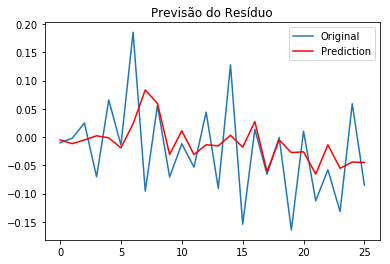

In [10]:
resid_pred = model_resid.predict(X_error_test)
plt.plot(y_error_test, label = 'Original')
plt.plot(resid_pred, label = 'Prediction', color = 'red')
plt.title('Previsão do Resíduo')
plt.legend()

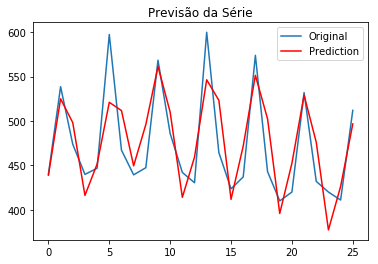

In [55]:
plt.plot(functions.desnormalizar(y_test[3:], data), label = 'Original')
plt.plot(functions.desnormalizar(y_pred[3:] + resid_pred,data), label = 'Prediction', color = 'red')
plt.title('Previsão da Série')
plt.legend()

# Modelo Proposto 2:

<img src="model2.png">

In [13]:
X_train_e = np.hstack((X_train[1:, :], resid_train[:-1].reshape(-1, 1)))
X_test_e = np.hstack((X_test[1:, :], resid_test[:-1].reshape(-1,1)))

In [43]:
model2 = hybrid_ann.Hybrid_ANN(model.weight)
model2.fit_MPSO(X = X_train_e, y = y_train[1:], d= 40, c1i = 0.5, c1f = 1.5, c2i = 0.5, c2f = 1.5, w1 = 0.2, w2 = 0.8, maxt = 2000)

In [57]:
y_pred2 = model2.predict(X_test_e)

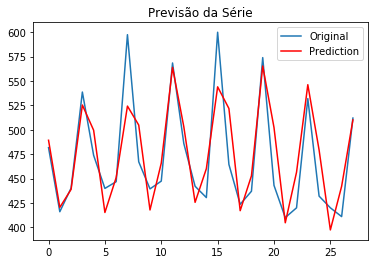

In [56]:
plt.plot(functions.desnormalizar(y_test[1:],data), label = 'Original')
plt.plot(functions.desnormalizar(y_pred2, data) , label = 'Prediction', color = 'red')
plt.title('Previsão da Série')
plt.legend()

## Comparação entre os modelos

### RBF

In [98]:
rbf = RBF(5, 2, 1)
rbf.train(X_train, y_train)
z = rbf.test(X_test)

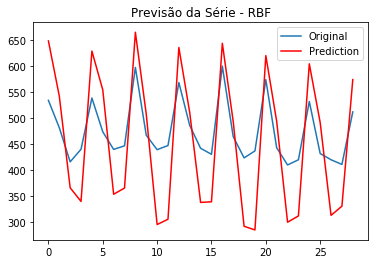

In [100]:
plt.plot(functions.desnormalizar(y_test, data), label = 'Original')
plt.plot(functions.desnormalizar(z,data) , label = 'Prediction', color = 'red')
plt.title('Previsão da Série - RBF')
plt.legend()

### FFANN

In [135]:
ffann = MLPRegressor(hidden_layer_sizes=(10,),activation= 'relu',solver='adam', max_iter=1000)
ffann.fit(X_train, y_train)
ffann_pred = ffann.predict(X_test)

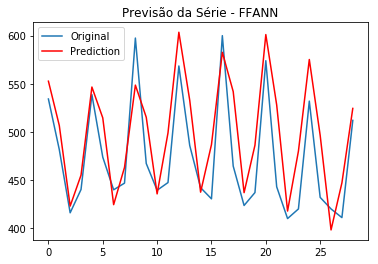

In [137]:
plt.plot(functions.desnormalizar(y_test, data), label = 'Original')
plt.plot(functions.desnormalizar(ffann_pred, data) , label = 'Prediction', color = 'red')
plt.title('Previsão da Série - FFANN')
plt.legend()

### WMES

In [21]:
fit2 = ExponentialSmoothing(data[:-29], seasonal_periods = 4, trend='add', seasonal='mul').fit(use_boxcox=True)
wmes = fit2.forecast(29)

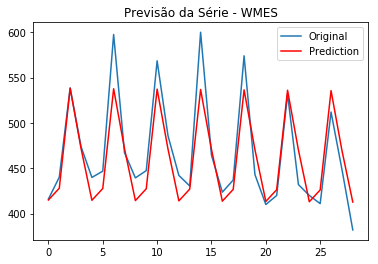

In [22]:
plt.plot(data[-29:], label = 'Original')
plt.plot(wmes , label = 'Prediction', color = 'red')
plt.title('Previsão da Série - WMES')
plt.legend()

### SARIMA

In [25]:
mod = sm.tsa.statespace.SARIMAX(data[:-29], trend='n', order=(0,1,0), seasonal_order=(1,1,1,12))
res = mod.fit()
sarima = res.predict(start = 124, end= 124+28, dynamic= True) 

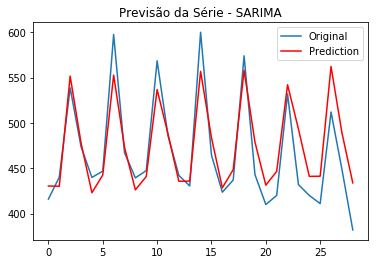

In [26]:
plt.plot(data[-29:], label = 'Original')
plt.plot(sarima , label = 'Prediction', color = 'red')
plt.title('Previsão da Série - SARIMA')
plt.legend()

# Resultados

In [150]:
Forecasts = pd.DataFrame(
{
'Test data': y_test,
'SARIMA': sarima,
'WMES': wmes,
'FFANN': ffann_pred,
'RBF': z,
'L&NL-ANN': y_pred
}
)

Metrics = pd.DataFrame(
{
'SARIMA': [functions.RMSE(y_test, sarima), functions.MAPE(y_test, sarima), functions.MdAPE(y_test, sarima), functions.DA(y_test, sarima)],
'WMES': [functions.RMSE(y_test, wmes), functions.MAPE(y_test, wmes), functions.MdAPE(y_test, wmes), functions.DA(y_test, wmes)],
'FFANN': [functions.RMSE(y_test, ffann_pred), functions.MAPE(y_test, ffann_pred), functions.MdAPE(y_test, ffann_pred), functions.DA(y_test, ffann_pred)],
'RBF': [functions.RMSE(y_test, z), functions.MAPE(y_test, z), functions.MdAPE(y_test, z), functions.DA(y_test, z)],
'L&NL-ANN': [functions.RMSE(y_test, y_pred), functions.MAPE(y_test, y_pred), functions.MdAPE(y_test, y_pred), functions.DA(y_test, y_pred)],
}, index = ['RMSE', 'MAPE', 'MdAPE', 'DA']
)

#Falta criar os outros modelos e inserir os respectivos conjuntos de previsão em cada função de erro.

In [151]:
Forecasts.head()

,Test data,SARIMA,WMES,FFANN,RBF,L&NL-ANN
0,0.823829,430.414217,414.984336,0.873325,1.129747,0.825832
1,0.683266,430.154729,428.018033,0.750218,0.846150,0.706605
2,0.507363,551.649307,538.101164,0.526032,0.373907,0.517388
3,0.572155,478.064677,471.942084,0.612049,0.303438,0.574128
4,0.835877,423.014011,414.665391,0.857094,1.077553,0.810907


In [152]:
Metrics

,SARIMA,WMES,FFANN,RBF,L&NL-ANN
RMSE,476.927383,462.336527,0.106554,0.239220,0.081269
MAPE,763.330955,740.180077,0.140283,0.362336,0.098537
MdAPE,800.937229,773.343248,0.102453,0.325786,0.098805
DA,0.428571,0.428571,0.928571,0.750000,0.928571


In [153]:
Metrics2 = pd.DataFrame(
{
'RMSE': [functions.RMSE(y_test, y_pred), functions.RMSE(y_test[3:], y_pred[3:] + resid_pred), functions.RMSE(y_test[1:], y_pred2)],
'MAPE': [functions.MAPE(y_test, y_pred), functions.MAPE(y_test[3:], y_pred[3:] + resid_pred),functions.MAPE(y_test[1:], y_pred2)],
'MdAPE': [functions.MdAPE(y_test, y_pred), functions.MdAPE(y_test[3:], y_pred[3:] + resid_pred),functions.MdAPE(y_test[1:], y_pred2)],
'DA': [functions.DA(y_test, y_pred), functions.DA(y_test[3:], y_pred[3:] + resid_pred),functions.DA(y_test[1:], y_pred2)]
}, index = ['L&NL-ANN', 'L&NL-ANN Modified 1', 'L&NL-ANN Modified 2']
)

Metrics2

,RMSE,MAPE,MdAPE,DA
L&NL-ANN,0.081269,0.098537,0.098805,0.928571
L&NL-ANN Modified 1,0.092621,0.119414,0.104730,0.920000
L&NL-ANN Modified 2,0.081882,0.098761,0.079989,0.925926
